In [ ]:
GDRIVE_PWD = 'DenoisingAutoencoder'

try:
    from google.colab import drive
    import os
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    drive.mount('/content/gdrive', force_remount=True)
    root_dir = "/content/gdrive/My Drive/"
    base_dir = os.path.join(root_dir, GDRIVE_PWD)
    
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    os.chdir(base_dir)

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
  @staticmethod
  def build(width, height, depth, filters=(32, 64), latentDim=16):
    inputShape = (height, width, depth)
    chanDim = -1
    inputs = Input(shape=inputShape)
    x = inputs

    for f in filters:
      x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chanDim)(x)

    volumeSize = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latentDim)(x)

    encoder = Model(inputs, latent, name="encoder")

    latentInputs = Input(shape=(latentDim,))
    x = Dense(np.prod(volumeSize[1:]))(latentInputs)
    x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

    for f in filters[::-1]:
      x = Conv2DTranspose(f, (3, 3), strides=2,padding="same")(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chanDim)(x)

    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)

    decoder = Model(latentInputs, outputs, name="decoder")

    autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")

    return (encoder, decoder, autoencoder)

In [ ]:
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from keras.preprocessing.image import img_to_array
import cv2
import glob
import numpy as np
import argparse

# construct the argument parse and parse the arguments
#np.random.seed(32)

# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 39
SIZE = 128

print("[INFO] loading dataset...")
trainX=[]
testX=[]
path1 = '/content/gdrive/MyDrive/Colab Notebooks/ImageDenoisingAutoencdoer-master/Train_11/all/'
path2 = '/content/gdrive/MyDrive/Colab Notebooks/ImageDenoisingAutoencdoer-master/Test_11/all/'
files=os.listdir(path1)
files1=os.listdir(path2)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i,0)   
    img=cv2.resize(img,(SIZE, SIZE))
    trainX.append(img_to_array(img))

for i in tqdm(files1):
    img=cv2.imread(path2+'/'+i,0)   
    try:
      img=cv2.resize(img,(SIZE, SIZE))
    except:
      break
    testX.append(img_to_array(img))

  1%|▏         | 18/1257 [00:00<00:06, 179.31it/s]

[INFO] loading dataset...


100%|██████████| 634/634 [00:03<00:00, 181.26it/s]


In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)
print(trainX.shape)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

#Adding speckle noise
trainNoise = 0.4 * np.random.normal(loc=0.5, scale= 0.3, size=trainX.shape)
testNoise = 0.4 * np.random.normal(loc=0.5, scale= 0.3, size=testX.shape)
trainXNoisy = np.clip(trainX + trainX * trainNoise, 0, 1)
testXNoisy = np.clip(testX + testX * testNoise, 0, 1)
print(trainXNoisy.shape)

(1257, 128, 128, 1)
(1257, 128, 128, 1)


In [ ]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()
train_gen= datagen.flow(trainXNoisy, trainX)
test_gen= datagen.flow(testXNoisy, testX)
trainXN, trainXY = next(train_gen)
print(trainXN.shape)

(32, 128, 128, 1)


In [ ]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(128, 128, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt, metrics = ['accuracy'])

es = EarlyStopping(monitor = 'val_loss', mode ='min', verbose = 1, patience = 10)
mc  = ModelCheckpoint('best_model.h5', monitor= 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

# train the convolutional autoencoder
H = autoencoder.fit_generator(
	train_gen,
  steps_per_epoch = 1257 // BS,
  epochs=EPOCHS,
	validation_data=(testXNoisy, testX),
  callbacks = [es, mc])
#for key in H.history:
  #print(key)
#print(autoencoder.summary())
print(encoder.summary())
print(decoder.summary())

saved_model = load_model('best_model.h5')

[INFO] building autoencoder...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
32/32 [==============================] - 53s 2s/step - loss: 0.1022 - accuracy: 0.1356 - val_loss: 0.0666 - val_accuracy: 0.1980

Epoch 00001: val_accuracy improved from -inf to 0.19803, saving model to best_model.h5
Epoch 2/25
32/32 [==============================] - 51s 2s/step - loss: 0.0299 - accuracy: 0.1722 - val_loss: 0.0500 - val_accuracy: 0.1976

Epoch 00002: val_accuracy did not improve from 0.19803
Epoch 3/25
32/32 [==============================] - 53s 2s/step - loss: 0.0189 - accuracy: 0.1644 - val_loss: 0.0374 - val_accuracy: 0.1981

Epoch 00003: val_accuracy improved from 0.19803 to 0.19808, saving model to best_model.h5
Epoch 4/25
32/32 [==============================] - 52s 2s/step - loss: 0.0141 - accuracy: 0.1670 - val_loss: 0.0327 - val_accuracy: 0.1981

Epoch 00004: val_accuracy improved from 0.19808 to 0.19811, saving model to best_model.h5
Epoch 5/25
32/32 [==============================] - 51s 2s/step - loss: 0.0127 - accuracy: 0.1719 - val_loss: 0.02

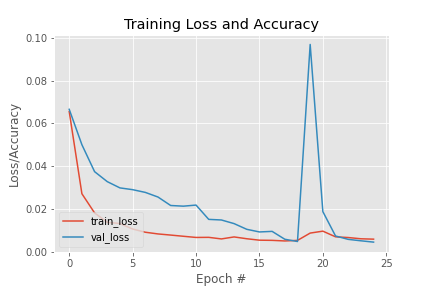

In [ ]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/ImageDenoisingAutoencdoer-master/plot_denoising.png')
img = Image.open('/content/gdrive/MyDrive/Colab Notebooks/ImageDenoisingAutoencdoer-master/plot_denoising.png')
img

In [ ]:
test_loss,test_acc = saved_model.evaluate(testXNoisy, testX, verbose = 0)
print('Test_loss: %.3f, Test_accuracy: %.3f '%(test_loss,test_acc))

Test_loss: 0.006, Test_accuracy: 0.198 


[INFO] making predictions...


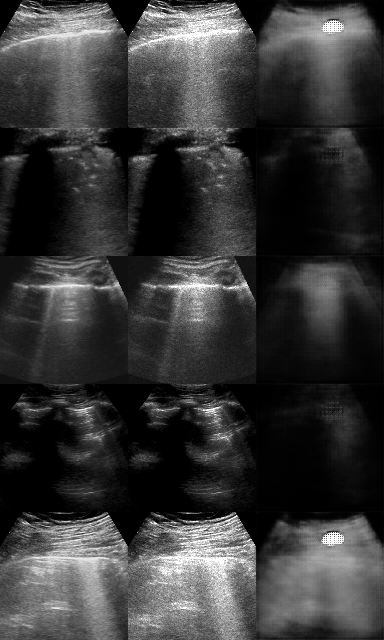

In [ ]:
print("[INFO] making predictions...")
decoded = saved_model.predict(testX)
outputs = None

for i in range(0, 5):
  
  original = (testXNoisy[i] * 255).astype("uint8")
  testX1 = (testX[i] * 255).astype("uint8")
  #original = original[:, :, :,0]
  #testX1 = testX1[:, :, :,0]
  recon = (decoded[i] * 255).astype("uint8")

  output = np.hstack([testX1,original, recon])

  if outputs is None:
    outputs = output
 
  else:
    outputs = np.vstack([outputs, output])

# save the outputs image to disk
cv2.imwrite("/content/gdrive/MyDrive/Colab Notebooks/ImageDenoisingAutoencdoer-master/output_denoising.png", outputs)
img = Image.open('/content/gdrive/MyDrive/Colab Notebooks/ImageDenoisingAutoencdoer-master/output_denoising.png')
img